In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])


class NMINSTImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images1 = np.load(img_dir_file + 'train_MNIST_Voxel1_exp_x_resolution.npy').astype(np.float32)
        self.labels1 = np.load(img_dir_file + 'train_MNIST_Voxel1_exp_y_resolution.npy')
        self.images2 = np.load(img_dir_file + 'train_MNIST_Voxel2_exp_x_resolution.npy').astype(np.float32)
        self.labels2 = np.load(img_dir_file + 'train_MNIST_Voxel2_exp_y_resolution.npy')
        self.images3 = np.load(img_dir_file + 'train_MNIST_Voxel3_exp_x_resolution.npy').astype(np.float32)
        self.labels3 = np.load(img_dir_file + 'train_MNIST_Voxel3_exp_y_resolution.npy')

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels1) + len(self.labels2) + len(self.labels3)

    def __getitem__(self, idx):
        if idx//10000 == 0:
            image = self.images1[idx%10000]
            label = self.labels1[idx%10000]
        elif idx//10000 == 1:
            image = self.images2[idx%10000]
            label = self.labels2[idx%10000]
        elif idx//10000 == 2:
            image = self.images3[idx%10000]
            label = self.labels3[idx%10000]

        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
        
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NMINSTImageDataset("Datasety/", transform=transforms)
generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.relu(out, inplace=False)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_chanels = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_chanels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.relu(x, inplace=False)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.96)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_MINST-DVS_ReLU_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected_exp.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_chanels=5).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, mom

### Copy weights

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): Batch

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90)

100%|██████████| 657/657 [02:39<00:00,  4.11it/s]


Epoch [1/120], Step [657/657], Loss: 6.0504, Accuracy: 0.1525
Accuracy of the network: 0.227 Loss: 1.8711708128875029


100%|██████████| 657/657 [02:39<00:00,  4.11it/s]


Epoch [2/120], Step [657/657], Loss: 1.7740, Accuracy: 0.2887
Accuracy of the network: 0.4256666666666667 Loss: 1.4224469839258398


100%|██████████| 657/657 [02:39<00:00,  4.12it/s]


Epoch [3/120], Step [657/657], Loss: 1.2564, Accuracy: 0.5045
Accuracy of the network: 0.5302222222222223 Loss: 1.2542314901419565


100%|██████████| 657/657 [02:40<00:00,  4.10it/s]


Epoch [4/120], Step [657/657], Loss: 1.0126, Accuracy: 0.6182
Accuracy of the network: 0.6271111111111111 Loss: 0.9922624154293791


100%|██████████| 657/657 [02:41<00:00,  4.08it/s]


Epoch [5/120], Step [657/657], Loss: 0.8911, Accuracy: 0.6712
Accuracy of the network: 0.7203333333333334 Loss: 0.7548601749940966


100%|██████████| 657/657 [02:42<00:00,  4.05it/s]


Epoch [6/120], Step [657/657], Loss: 0.8434, Accuracy: 0.6922
Accuracy of the network: 0.7418888888888889 Loss: 0.730827752262988


100%|██████████| 657/657 [02:40<00:00,  4.10it/s]


Epoch [7/120], Step [657/657], Loss: 0.8141, Accuracy: 0.7027
Accuracy of the network: 0.6987777777777778 Loss: 0.7730428467616968


100%|██████████| 657/657 [02:40<00:00,  4.10it/s]


Epoch [8/120], Step [657/657], Loss: 0.7727, Accuracy: 0.7200
Accuracy of the network: 0.6952222222222222 Loss: 0.80014594639024


100%|██████████| 657/657 [02:40<00:00,  4.10it/s]


Epoch [9/120], Step [657/657], Loss: 0.7478, Accuracy: 0.7289
Accuracy of the network: 0.7562222222222222 Loss: 0.6839743975206469


100%|██████████| 657/657 [02:39<00:00,  4.11it/s]


Epoch [10/120], Step [657/657], Loss: 0.7367, Accuracy: 0.7362
Accuracy of the network: 0.767 Loss: 0.6299048378429515


100%|██████████| 657/657 [02:39<00:00,  4.11it/s]


Epoch [11/120], Step [657/657], Loss: 0.7121, Accuracy: 0.7415
Accuracy of the network: 0.66 Loss: 0.9480078115742258


100%|██████████| 657/657 [02:39<00:00,  4.11it/s]


Epoch [12/120], Step [657/657], Loss: 0.6914, Accuracy: 0.7492
Accuracy of the network: 0.8028888888888889 Loss: 0.5481237532399225


100%|██████████| 657/657 [02:40<00:00,  4.10it/s]


Epoch [13/120], Step [657/657], Loss: 0.6758, Accuracy: 0.7561
Accuracy of the network: 0.7704444444444445 Loss: 0.6380544817405389


100%|██████████| 657/657 [02:39<00:00,  4.12it/s]


Epoch [14/120], Step [657/657], Loss: 0.6672, Accuracy: 0.7637
Accuracy of the network: 0.7926666666666666 Loss: 0.5609912075472216


100%|██████████| 657/657 [02:37<00:00,  4.17it/s]


Epoch [15/120], Step [657/657], Loss: 0.6572, Accuracy: 0.7667
Accuracy of the network: 0.7776666666666666 Loss: 0.6402044349634055


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [16/120], Step [657/657], Loss: 0.6288, Accuracy: 0.7765
Accuracy of the network: 0.8013333333333333 Loss: 0.5637272864791518


100%|██████████| 657/657 [02:35<00:00,  4.22it/s]


Epoch [17/120], Step [657/657], Loss: 0.6275, Accuracy: 0.7744
Accuracy of the network: 0.8018888888888889 Loss: 0.543267050269225


100%|██████████| 657/657 [02:34<00:00,  4.25it/s]


Epoch [18/120], Step [657/657], Loss: 0.6062, Accuracy: 0.7840
Accuracy of the network: 0.838 Loss: 0.49149484625944856


100%|██████████| 657/657 [02:36<00:00,  4.21it/s]


Epoch [19/120], Step [657/657], Loss: 0.5913, Accuracy: 0.7931
Accuracy of the network: 0.8035555555555556 Loss: 0.5517481060579736


100%|██████████| 657/657 [02:33<00:00,  4.28it/s]


Epoch [20/120], Step [657/657], Loss: 0.5723, Accuracy: 0.7967
Accuracy of the network: 0.8233333333333334 Loss: 0.5160458983047634


100%|██████████| 657/657 [02:35<00:00,  4.23it/s]


Epoch [21/120], Step [657/657], Loss: 0.5804, Accuracy: 0.7964
Accuracy of the network: 0.8433333333333334 Loss: 0.45337289571762085


100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Epoch [22/120], Step [657/657], Loss: 0.5702, Accuracy: 0.8031
Accuracy of the network: 0.8223333333333334 Loss: 0.5286805815730534


100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Epoch [23/120], Step [657/657], Loss: 0.5519, Accuracy: 0.8072
Accuracy of the network: 0.8421111111111111 Loss: 0.4573975937269258


100%|██████████| 657/657 [02:37<00:00,  4.16it/s]


Epoch [24/120], Step [657/657], Loss: 0.5444, Accuracy: 0.8085
Accuracy of the network: 0.8352222222222222 Loss: 0.4649919366582911


100%|██████████| 657/657 [02:45<00:00,  3.96it/s]


Epoch [25/120], Step [657/657], Loss: 0.5530, Accuracy: 0.8068
Accuracy of the network: 0.8528888888888889 Loss: 0.4406292789371301


100%|██████████| 657/657 [02:42<00:00,  4.03it/s]


Epoch [26/120], Step [657/657], Loss: 0.5372, Accuracy: 0.8114
Accuracy of the network: 0.851 Loss: 0.4424169005443018


100%|██████████| 657/657 [02:34<00:00,  4.26it/s]


Epoch [27/120], Step [657/657], Loss: 0.5227, Accuracy: 0.8185
Accuracy of the network: 0.8202222222222222 Loss: 0.5255981390463546


100%|██████████| 657/657 [02:34<00:00,  4.24it/s]


Epoch [28/120], Step [657/657], Loss: 0.5145, Accuracy: 0.8193
Accuracy of the network: 0.8665555555555555 Loss: 0.40328756128008486


100%|██████████| 657/657 [02:35<00:00,  4.22it/s]


Epoch [29/120], Step [657/657], Loss: 0.5119, Accuracy: 0.8209
Accuracy of the network: 0.8797777777777778 Loss: 0.37323080317665497


100%|██████████| 657/657 [02:35<00:00,  4.22it/s]


Epoch [30/120], Step [657/657], Loss: 0.5016, Accuracy: 0.8270
Accuracy of the network: 0.8356666666666667 Loss: 0.4918669287300279


100%|██████████| 657/657 [02:34<00:00,  4.25it/s]


Epoch [31/120], Step [657/657], Loss: 0.4867, Accuracy: 0.8317
Accuracy of the network: 0.8648888888888889 Loss: 0.4172555056552515


100%|██████████| 657/657 [02:34<00:00,  4.25it/s]


Epoch [32/120], Step [657/657], Loss: 0.4767, Accuracy: 0.8373
Accuracy of the network: 0.8607777777777778 Loss: 0.4127713568667148


100%|██████████| 657/657 [02:36<00:00,  4.21it/s]


Epoch [33/120], Step [657/657], Loss: 0.4773, Accuracy: 0.8334
Accuracy of the network: 0.8702222222222222 Loss: 0.397768395616019


100%|██████████| 657/657 [02:34<00:00,  4.24it/s]


Epoch [34/120], Step [657/657], Loss: 0.4652, Accuracy: 0.8392
Accuracy of the network: 0.8457777777777777 Loss: 0.4690176989909605


100%|██████████| 657/657 [02:34<00:00,  4.24it/s]


Epoch [35/120], Step [657/657], Loss: 0.4454, Accuracy: 0.8490
Accuracy of the network: 0.8794444444444445 Loss: 0.3778681994964045


100%|██████████| 657/657 [02:31<00:00,  4.33it/s]


Epoch [36/120], Step [657/657], Loss: 0.4477, Accuracy: 0.8457
Accuracy of the network: 0.8656666666666667 Loss: 0.40751696840351354


100%|██████████| 657/657 [02:32<00:00,  4.32it/s]


Epoch [37/120], Step [657/657], Loss: 0.4303, Accuracy: 0.8541
Accuracy of the network: 0.8914444444444445 Loss: 0.3405558810642002


100%|██████████| 657/657 [02:32<00:00,  4.32it/s]


Epoch [38/120], Step [657/657], Loss: 0.4341, Accuracy: 0.8518
Accuracy of the network: 0.864 Loss: 0.40298588439188104


100%|██████████| 657/657 [02:35<00:00,  4.22it/s]


Epoch [39/120], Step [657/657], Loss: 0.4346, Accuracy: 0.8497
Accuracy of the network: 0.8874444444444445 Loss: 0.35441871906848665


100%|██████████| 657/657 [02:50<00:00,  3.85it/s]


Epoch [40/120], Step [657/657], Loss: 0.4206, Accuracy: 0.8570
Accuracy of the network: 0.8983333333333333 Loss: 0.3135115933862138


100%|██████████| 657/657 [02:40<00:00,  4.09it/s]


Epoch [41/120], Step [657/657], Loss: 0.4137, Accuracy: 0.8616
Accuracy of the network: 0.8796666666666667 Loss: 0.36923418907409017


100%|██████████| 657/657 [02:33<00:00,  4.29it/s]


Epoch [42/120], Step [657/657], Loss: 0.4036, Accuracy: 0.8645
Accuracy of the network: 0.8986666666666666 Loss: 0.3137381253301675


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [43/120], Step [657/657], Loss: 0.3991, Accuracy: 0.8636
Accuracy of the network: 0.8846666666666667 Loss: 0.3493618610585835


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [44/120], Step [657/657], Loss: 0.3951, Accuracy: 0.8671
Accuracy of the network: 0.8933333333333333 Loss: 0.332591448573673


100%|██████████| 657/657 [02:33<00:00,  4.28it/s]


Epoch [45/120], Step [657/657], Loss: 0.3939, Accuracy: 0.8668
Accuracy of the network: 0.882 Loss: 0.36579656820242284


100%|██████████| 657/657 [02:33<00:00,  4.28it/s]


Epoch [46/120], Step [657/657], Loss: 0.3824, Accuracy: 0.8704
Accuracy of the network: 0.9102222222222223 Loss: 0.2852266136926751


100%|██████████| 657/657 [02:33<00:00,  4.28it/s]


Epoch [47/120], Step [657/657], Loss: 0.3784, Accuracy: 0.8703
Accuracy of the network: 0.8851111111111111 Loss: 0.3517600923565263


100%|██████████| 657/657 [02:34<00:00,  4.26it/s]


Epoch [48/120], Step [657/657], Loss: 0.3732, Accuracy: 0.8753
Accuracy of the network: 0.9037777777777778 Loss: 0.304076510356039


100%|██████████| 657/657 [02:34<00:00,  4.26it/s]


Epoch [49/120], Step [657/657], Loss: 0.3651, Accuracy: 0.8759
Accuracy of the network: 0.9118888888888889 Loss: 0.2826406489925604


100%|██████████| 657/657 [02:35<00:00,  4.23it/s]


Epoch [50/120], Step [657/657], Loss: 0.3625, Accuracy: 0.8789
Accuracy of the network: 0.8804444444444445 Loss: 0.35230021576350884


100%|██████████| 657/657 [02:34<00:00,  4.24it/s]


Epoch [51/120], Step [657/657], Loss: 0.3469, Accuracy: 0.8832
Accuracy of the network: 0.9077777777777778 Loss: 0.2814497247549659


100%|██████████| 657/657 [02:33<00:00,  4.29it/s]


Epoch [52/120], Step [657/657], Loss: 0.3472, Accuracy: 0.8832
Accuracy of the network: 0.9108888888888889 Loss: 0.2837320659705933


100%|██████████| 657/657 [02:33<00:00,  4.29it/s]


Epoch [53/120], Step [657/657], Loss: 0.3479, Accuracy: 0.8854
Accuracy of the network: 0.9084444444444445 Loss: 0.2787578913072745


100%|██████████| 657/657 [02:36<00:00,  4.20it/s]


Epoch [54/120], Step [657/657], Loss: 0.3385, Accuracy: 0.8855
Accuracy of the network: 0.916 Loss: 0.25952193150230757


100%|██████████| 657/657 [02:37<00:00,  4.18it/s]


Epoch [55/120], Step [657/657], Loss: 0.3375, Accuracy: 0.8896
Accuracy of the network: 0.9038888888888889 Loss: 0.3017972875518579


100%|██████████| 657/657 [02:31<00:00,  4.34it/s]


Epoch [56/120], Step [657/657], Loss: 0.3379, Accuracy: 0.8867
Accuracy of the network: 0.9227777777777778 Loss: 0.2499701442289437


100%|██████████| 657/657 [02:30<00:00,  4.36it/s]


Epoch [57/120], Step [657/657], Loss: 0.3268, Accuracy: 0.8910
Accuracy of the network: 0.9122222222222223 Loss: 0.270400834236796


100%|██████████| 657/657 [02:29<00:00,  4.38it/s]


Epoch [58/120], Step [657/657], Loss: 0.3314, Accuracy: 0.8883
Accuracy of the network: 0.9037777777777778 Loss: 0.29333771289663113


100%|██████████| 657/657 [02:29<00:00,  4.38it/s]


Epoch [59/120], Step [657/657], Loss: 0.3231, Accuracy: 0.8920
Accuracy of the network: 0.9166666666666666 Loss: 0.2636714567635076


100%|██████████| 657/657 [02:34<00:00,  4.26it/s]


Epoch [60/120], Step [657/657], Loss: 0.3093, Accuracy: 0.8965
Accuracy of the network: 0.9202222222222223 Loss: 0.25636596256431116


100%|██████████| 657/657 [02:33<00:00,  4.28it/s]


Epoch [61/120], Step [657/657], Loss: 0.3170, Accuracy: 0.8956
Accuracy of the network: 0.9257777777777778 Loss: 0.24599124693331567


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [62/120], Step [657/657], Loss: 0.3047, Accuracy: 0.8990
Accuracy of the network: 0.9214444444444444 Loss: 0.25636829902147146


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [63/120], Step [657/657], Loss: 0.3069, Accuracy: 0.8987
Accuracy of the network: 0.9134444444444444 Loss: 0.2755106906968017


100%|██████████| 657/657 [02:34<00:00,  4.27it/s]


Epoch [64/120], Step [657/657], Loss: 0.3031, Accuracy: 0.9018
Accuracy of the network: 0.9201111111111111 Loss: 0.2577283515971392


100%|██████████| 657/657 [02:32<00:00,  4.30it/s]


Epoch [65/120], Step [657/657], Loss: 0.2987, Accuracy: 0.9031
Accuracy of the network: 0.9216666666666666 Loss: 0.24870142090986383


100%|██████████| 657/657 [02:33<00:00,  4.29it/s]


Epoch [66/120], Step [657/657], Loss: 0.2934, Accuracy: 0.9019
Accuracy of the network: 0.9274444444444444 Loss: 0.23268418704945568


100%|██████████| 657/657 [02:33<00:00,  4.28it/s]


Epoch [67/120], Step [657/657], Loss: 0.2918, Accuracy: 0.9031
Accuracy of the network: 0.9216666666666666 Loss: 0.24874132505703903


100%|██████████| 657/657 [02:33<00:00,  4.29it/s]


Epoch [68/120], Step [657/657], Loss: 0.2818, Accuracy: 0.9097
Accuracy of the network: 0.9255555555555556 Loss: 0.23151139495564058


100%|██████████| 657/657 [02:32<00:00,  4.32it/s]


Epoch [69/120], Step [657/657], Loss: 0.2844, Accuracy: 0.9063
Accuracy of the network: 0.9283333333333333 Loss: 0.224310726515209


100%|██████████| 657/657 [02:33<00:00,  4.28it/s]


Epoch [70/120], Step [657/657], Loss: 0.2717, Accuracy: 0.9103
Accuracy of the network: 0.9278888888888889 Loss: 0.23504146957334052


100%|██████████| 657/657 [02:33<00:00,  4.29it/s]


Epoch [71/120], Step [657/657], Loss: 0.2733, Accuracy: 0.9090
Accuracy of the network: 0.9314444444444444 Loss: 0.2169201157471918


100%|██████████| 657/657 [02:34<00:00,  4.25it/s]


Epoch [72/120], Step [657/657], Loss: 0.2715, Accuracy: 0.9114
Accuracy of the network: 0.9321111111111111 Loss: 0.2238492974284904


100%|██████████| 657/657 [02:31<00:00,  4.34it/s]


Epoch [73/120], Step [657/657], Loss: 0.2641, Accuracy: 0.9134
Accuracy of the network: 0.93 Loss: 0.22617359545266796


100%|██████████| 657/657 [02:33<00:00,  4.28it/s]


Epoch [74/120], Step [657/657], Loss: 0.2614, Accuracy: 0.9160
Accuracy of the network: 0.9314444444444444 Loss: 0.22566202577494138


100%|██████████| 657/657 [02:28<00:00,  4.41it/s]


Epoch [75/120], Step [657/657], Loss: 0.2652, Accuracy: 0.9120
Accuracy of the network: 0.9328888888888889 Loss: 0.20985285037507614


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [76/120], Step [657/657], Loss: 0.2555, Accuracy: 0.9174
Accuracy of the network: 0.9281111111111111 Loss: 0.22462767766828232


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [77/120], Step [657/657], Loss: 0.2520, Accuracy: 0.9162
Accuracy of the network: 0.9381111111111111 Loss: 0.1963703463659853


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [78/120], Step [657/657], Loss: 0.2481, Accuracy: 0.9195
Accuracy of the network: 0.9301111111111111 Loss: 0.22000880235581532


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [79/120], Step [657/657], Loss: 0.2492, Accuracy: 0.9207
Accuracy of the network: 0.9394444444444444 Loss: 0.19384774652884362


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [80/120], Step [657/657], Loss: 0.2525, Accuracy: 0.9160
Accuracy of the network: 0.9357777777777778 Loss: 0.20737837904945333


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [81/120], Step [657/657], Loss: 0.2431, Accuracy: 0.9203
Accuracy of the network: 0.9343333333333333 Loss: 0.20633667320382934


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [82/120], Step [657/657], Loss: 0.2406, Accuracy: 0.9206
Accuracy of the network: 0.9301111111111111 Loss: 0.2178115349474317


100%|██████████| 657/657 [02:28<00:00,  4.44it/s]


Epoch [83/120], Step [657/657], Loss: 0.2386, Accuracy: 0.9238
Accuracy of the network: 0.9412222222222222 Loss: 0.19912954398054392


100%|██████████| 657/657 [02:28<00:00,  4.44it/s]


Epoch [84/120], Step [657/657], Loss: 0.2381, Accuracy: 0.9223
Accuracy of the network: 0.9416666666666667 Loss: 0.1835328205257443


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [85/120], Step [657/657], Loss: 0.2298, Accuracy: 0.9242
Accuracy of the network: 0.94 Loss: 0.19039262387346714


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [86/120], Step [657/657], Loss: 0.2288, Accuracy: 0.9260
Accuracy of the network: 0.9396666666666667 Loss: 0.1924450807603644


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [87/120], Step [657/657], Loss: 0.2279, Accuracy: 0.9262
Accuracy of the network: 0.9437777777777778 Loss: 0.1819311146498889


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [88/120], Step [657/657], Loss: 0.2266, Accuracy: 0.9258
Accuracy of the network: 0.9406666666666667 Loss: 0.18980252792305768


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [89/120], Step [657/657], Loss: 0.2184, Accuracy: 0.9282
Accuracy of the network: 0.941 Loss: 0.18815636138121286


100%|██████████| 657/657 [02:28<00:00,  4.44it/s]


Epoch [90/120], Step [657/657], Loss: 0.2213, Accuracy: 0.9284
Accuracy of the network: 0.9446666666666667 Loss: 0.1785601328279004


100%|██████████| 657/657 [02:27<00:00,  4.44it/s]


Epoch [91/120], Step [657/657], Loss: 0.2148, Accuracy: 0.9299
Accuracy of the network: 0.9396666666666667 Loss: 0.19469747309249344


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [92/120], Step [657/657], Loss: 0.2126, Accuracy: 0.9310
Accuracy of the network: 0.9454444444444444 Loss: 0.17892066656169317


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [93/120], Step [657/657], Loss: 0.2092, Accuracy: 0.9322
Accuracy of the network: 0.9493333333333334 Loss: 0.17017768287753804


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [94/120], Step [657/657], Loss: 0.2141, Accuracy: 0.9295
Accuracy of the network: 0.9422222222222222 Loss: 0.18793331225343207


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [95/120], Step [657/657], Loss: 0.2128, Accuracy: 0.9308
Accuracy of the network: 0.9484444444444444 Loss: 0.1704992079935598


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [96/120], Step [657/657], Loss: 0.2113, Accuracy: 0.9323
Accuracy of the network: 0.946 Loss: 0.17500574194581797


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [97/120], Step [657/657], Loss: 0.2069, Accuracy: 0.9324
Accuracy of the network: 0.9494444444444444 Loss: 0.16654903046020592


100%|██████████| 657/657 [02:27<00:00,  4.44it/s]


Epoch [98/120], Step [657/657], Loss: 0.2031, Accuracy: 0.9342
Accuracy of the network: 0.9443333333333334 Loss: 0.18431898403965624


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [99/120], Step [657/657], Loss: 0.2051, Accuracy: 0.9339
Accuracy of the network: 0.953 Loss: 0.16279829148837227


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [100/120], Step [657/657], Loss: 0.2001, Accuracy: 0.9366
Accuracy of the network: 0.9503333333333334 Loss: 0.16230845769721988


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [101/120], Step [657/657], Loss: 0.2005, Accuracy: 0.9375
Accuracy of the network: 0.943 Loss: 0.18709736555841164


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [102/120], Step [657/657], Loss: 0.1960, Accuracy: 0.9370
Accuracy of the network: 0.9494444444444444 Loss: 0.16214116509171558


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [103/120], Step [657/657], Loss: 0.2020, Accuracy: 0.9355
Accuracy of the network: 0.9475555555555556 Loss: 0.16673196072802476


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [104/120], Step [657/657], Loss: 0.1925, Accuracy: 0.9378
Accuracy of the network: 0.9507777777777778 Loss: 0.16268763275724565


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [105/120], Step [657/657], Loss: 0.1926, Accuracy: 0.9374
Accuracy of the network: 0.9532222222222222 Loss: 0.16146848338874095


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [106/120], Step [657/657], Loss: 0.1885, Accuracy: 0.9392
Accuracy of the network: 0.9528888888888889 Loss: 0.16266397705816843


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [107/120], Step [657/657], Loss: 0.1890, Accuracy: 0.9399
Accuracy of the network: 0.9503333333333334 Loss: 0.1604935885374005


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [108/120], Step [657/657], Loss: 0.1841, Accuracy: 0.9416
Accuracy of the network: 0.9513333333333334 Loss: 0.1595231746389458


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [109/120], Step [657/657], Loss: 0.1855, Accuracy: 0.9424
Accuracy of the network: 0.9528888888888889 Loss: 0.16250649890168867


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [110/120], Step [657/657], Loss: 0.1797, Accuracy: 0.9410
Accuracy of the network: 0.9498888888888889 Loss: 0.16596154295938445


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [111/120], Step [657/657], Loss: 0.1859, Accuracy: 0.9422
Accuracy of the network: 0.952 Loss: 0.15663883079451027


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [112/120], Step [657/657], Loss: 0.1840, Accuracy: 0.9407
Accuracy of the network: 0.9536666666666667 Loss: 0.15269119892242952


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [113/120], Step [657/657], Loss: 0.1808, Accuracy: 0.9419
Accuracy of the network: 0.9513333333333334 Loss: 0.16046967919823443


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [114/120], Step [657/657], Loss: 0.1768, Accuracy: 0.9436
Accuracy of the network: 0.9531111111111111 Loss: 0.1558230236529353


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [115/120], Step [657/657], Loss: 0.1775, Accuracy: 0.9437
Accuracy of the network: 0.9513333333333334 Loss: 0.15426516014395664


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [116/120], Step [657/657], Loss: 0.1781, Accuracy: 0.9409
Accuracy of the network: 0.9553333333333334 Loss: 0.16043375150122224


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [117/120], Step [657/657], Loss: 0.1754, Accuracy: 0.9430
Accuracy of the network: 0.9531111111111111 Loss: 0.1550712830499343


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [118/120], Step [657/657], Loss: 0.1742, Accuracy: 0.9440
Accuracy of the network: 0.9567777777777777 Loss: 0.1479946588172663


100%|██████████| 657/657 [02:28<00:00,  4.44it/s]


Epoch [119/120], Step [657/657], Loss: 0.1763, Accuracy: 0.9433
Accuracy of the network: 0.9555555555555556 Loss: 0.15406437069243678


100%|██████████| 657/657 [02:28<00:00,  4.44it/s]


Epoch [120/120], Step [657/657], Loss: 0.1765, Accuracy: 0.9438
Accuracy of the network: 0.9557777777777777 Loss: 0.15148266028375068


In [10]:
torch.save(model, "best_resnet50_MINST-DVS_ReLU_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_exp.pt")


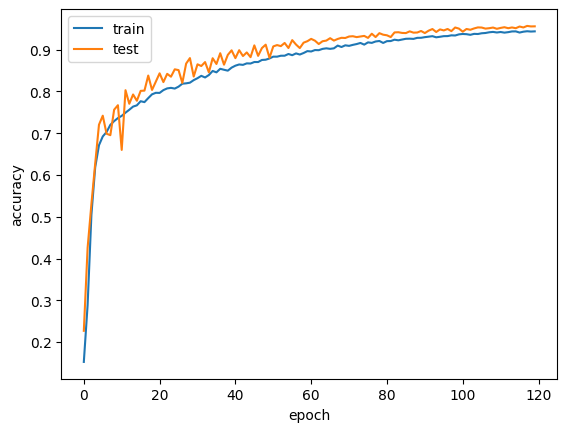

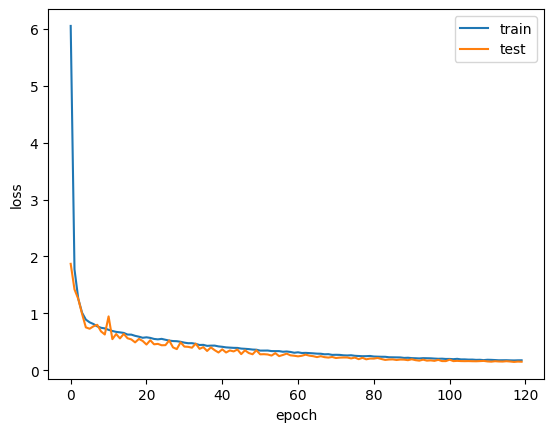

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet50_MINST-DVS_ReLU_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_exp.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.152524,0.227000,6.050384,1.871171
1,0.288667,0.425667,1.774042,1.422447
2,0.504476,0.530222,1.256408,1.254231
3,0.618238,0.627111,1.012616,0.992262
4,0.671190,0.720333,0.891074,0.754860


In [14]:
print(df["test_acc"].max())

0.9567777777777777


In [15]:
print(df.to_string())

     train_acc  test_acc  train_loss  test_loss
0     0.152524  0.227000    6.050384   1.871171
1     0.288667  0.425667    1.774042   1.422447
2     0.504476  0.530222    1.256408   1.254231
3     0.618238  0.627111    1.012616   0.992262
4     0.671190  0.720333    0.891074   0.754860
5     0.692238  0.741889    0.843389   0.730828
6     0.702714  0.698778    0.814115   0.773043
7     0.720000  0.695222    0.772678   0.800146
8     0.728905  0.756222    0.747849   0.683974
9     0.736190  0.767000    0.736681   0.629905
10    0.741476  0.660000    0.712101   0.948008
11    0.749190  0.802889    0.691381   0.548124
12    0.756095  0.770444    0.675804   0.638054
13    0.763667  0.792667    0.667152   0.560991
14    0.766667  0.777667    0.657236   0.640204
15    0.776524  0.801333    0.628825   0.563727
16    0.774381  0.801889    0.627498   0.543267
17    0.784000  0.838000    0.606180   0.491495
18    0.793095  0.803556    0.591337   0.551748
19    0.796667  0.823333    0.572338   0